# Cell State Identification

In [4]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import scvi
from sklearn.metrics import silhouette_score
from scvi.model import SCVI

In [10]:
flu_data = sc.read_h5ad("../data/inference/influenza_lee_czi_preds_hvg.h5ad")
# covid_data = sc.read_h5ad("../data/inference/covid_all_czi_preds.h5ad")

### Subset CD14⁺ monocytes from each dataset

In [11]:
# adata_covid_mono = covid_data[covid_data.obs["pred_coarse"] == "CD14+ monocyte"]
adata_flu_mono = flu_data[flu_data.obs["pred_coarse"] == "CD14+ monocyte"]
# del adata_covid_mono.obsm["X_pca"]
# del adata_flu_mono.obsm["X_pca"]
# del adata_covid_mono.obsm["X_pca_umap"]
# del adata_flu_mono.obsm["X_umap_pca"]

### Generate PCA and scVI embeddings for CD14 monocytes - COVID

In [5]:
# 2. Basic preprocessing for PCA
sc.pp.normalize_total(adata_covid_mono, target_sum=1e4)
sc.pp.log1p(adata_covid_mono)

# 3. PCA embedding
sc.pp.highly_variable_genes(adata_covid_mono, n_top_genes=2000, subset=False)
adata_covid_mono.raw = adata_covid_mono  # preserve full data before subsetting
sc.pp.pca(adata_covid_mono)
# Result stored in: adata.obsm["X_pca"]

# 4. Set up for scVI — use original raw counts
adata_covid_mono.layers["counts"] = adata_covid_mono.raw.X.copy()
scvi.model.SCVI.setup_anndata(adata_covid_mono, layer="counts", batch_key="dataset_id")

# 5. Train scVI (this selects HVGs internally!)
model = scvi.model.SCVI(adata_covid_mono, n_layers=2, n_latent=30, gene_likelihood="nb")
model.train()

# 6. Extract scVI latent embeddings
adata_covid_mono.obsm["X_scvi"] = model.get_latent_representation()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scvi/data/fields/_dataframe_field.py:186: UserWarning: Category 3 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You

Epoch 400/400: 100%|██████████| 400/400 [12:35<00:00,  1.88s/it, v_num=1, train_loss_step=4.29e+3, train_loss_epoch=4.3e+3] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [12:35<00:00,  1.89s/it, v_num=1, train_loss_step=4.29e+3, train_loss_epoch=4.3e+3]


In [6]:
for emb in ["pca","scvi", "scgpt"]:
    sc.pp.neighbors(adata_covid_mono, use_rep=f"X_{emb}")
    sc.tl.umap(adata_covid_mono)
    # Store UMAP coordinates from emb in a new layer
    adata_covid_mono.obsm[f"X_umap_{emb}"] = adata_covid_mono.obsm["X_umap"]
    sc.tl.leiden(adata_covid_mono, resolution=0.1, key_added=f"leiden_{emb}")

/tmp/ipykernel_2725286/2256934997.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_covid_mono, resolution=0.1, key_added=f"leiden_{emb}")


### Generate PCA and scVI embeddings for CD14 monocytes - Flu

In [9]:
# 2. Basic preprocessing for PCA
sc.pp.normalize_total(adata_flu_mono, target_sum=1e4)
sc.pp.log1p(adata_flu_mono)

# 3. PCA embedding
sc.pp.highly_variable_genes(adata_flu_mono, n_top_genes=2000, subset=False)
adata_flu_mono.raw = adata_flu_mono  # preserve full data before subsetting
sc.pp.pca(adata_flu_mono)
# Result stored in: adata.obsm["X_pca"]

# 4. Set up for scVI — use original raw counts
adata_flu_mono.layers["counts"] = adata_flu_mono.raw.X.copy()
scvi.model.SCVI.setup_anndata(adata_flu_mono, layer="counts", batch_key="dataset_id")

# 5. Train scVI (this selects HVGs internally!)
model = scvi.model.SCVI(adata_flu_mono, n_layers=2, n_latent=30, gene_likelihood="nb")
model.train()

# 6. Extract scVI latent embeddings
adata_flu_mono.obsm["X_scvi"] = model.get_latent_representation()

/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments 

Epoch 64/400:  16%|█▌        | 63/400 [00:19<01:42,  3.28it/s, v_num=1, train_loss_step=633, train_loss_epoch=625]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [9]:
for emb in ["pca", "scvi", "scgpt"]:
    # 1. Compute neighbors using specified embedding
    sc.pp.neighbors(adata_flu_mono, use_rep=f"X_{emb}")

    # 2. Run Leiden clustering using that embedding
    sc.tl.leiden(adata_flu_mono, resolution=0.2, key_added=f"leiden_{emb}")
    
    # 3. Run UMAP and store in a separate key
    sc.tl.umap(adata_flu_mono)
    adata_flu_mono.obsm[f"X_umap_{emb}"] = adata_flu_mono.obsm["X_umap"].copy()

In [10]:
adata_covid_mono.write_h5ad("../data/embeddings/covid_mono.h5ad")
adata_flu_mono.write_h5ad("../data/embeddings/flu_mono.h5ad")

### Dotplot for COVID - scGPT

/tmp/ipykernel_2725286/1186912933.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_df
/tmp/ipykernel_2725286/1186912933.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df


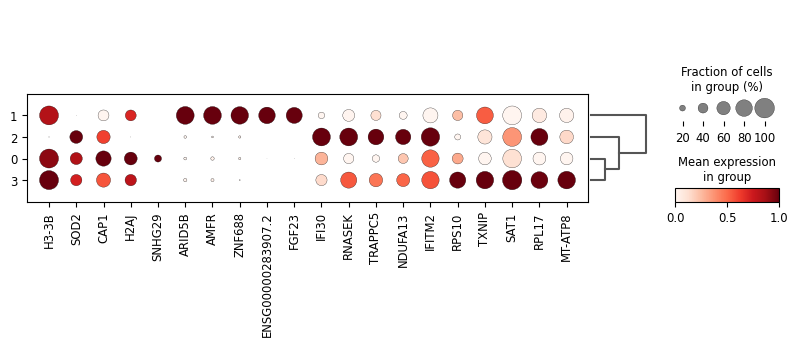

In [14]:
# Example usage:
covid_scgpt_markers, top_genes_covid_scgpt, ranked_genes_covid_scgpt = get_top_marker_genes(
    adata_covid_mono, groupby="leiden_scgpt", logfc_threshold=1.0, pval_threshold=0.05, top_n=5
)
sc.pl.dotplot(
    adata_covid_mono,
    var_names=covid_scgpt_markers,
    groupby="leiden_scgpt",
    standard_scale='var',
    dendrogram=True,
)

### Dotplot for COVID - PCA

/tmp/ipykernel_2725286/1186912933.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_df
/tmp/ipykernel_2725286/1186912933.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df


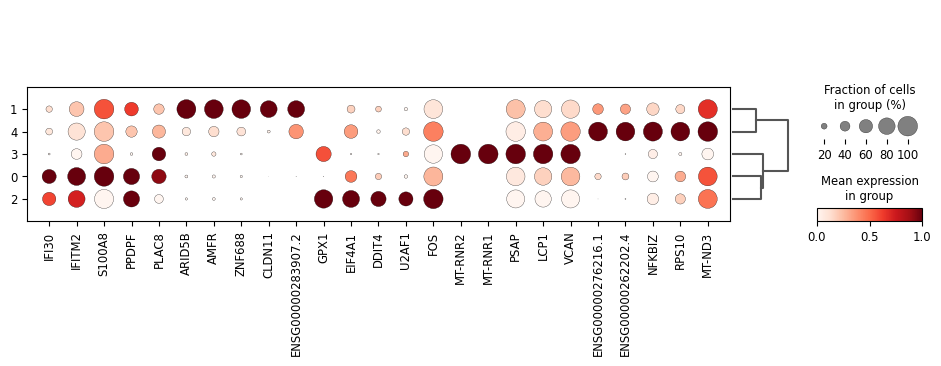

In [15]:
# Example usage:
covid_pca_markers, top_genes_covid_pca, ranked_genes_covid_pca = get_top_marker_genes(
    adata_covid_mono, groupby="leiden_pca", logfc_threshold=1.0, pval_threshold=0.05, top_n=5
)
sc.pl.dotplot(
    adata_covid_mono,
    var_names=covid_pca_markers,
    groupby="leiden_pca",
    standard_scale='var',
    dendrogram=True,
)

### Dotplot for COVID - scVI

/tmp/ipykernel_2725286/1186912933.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_df
/tmp/ipykernel_2725286/1186912933.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df


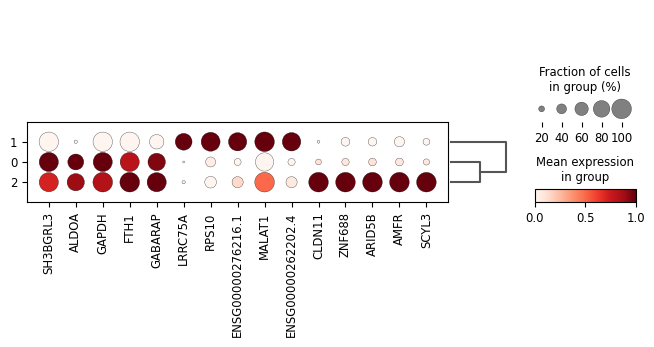

In [16]:
# Example usage:
covid_scvi_markers, top_genes_covid_scvi, ranked_genes_covid_scvi = get_top_marker_genes(
    adata_covid_mono, groupby="leiden_scvi", logfc_threshold=1.0, pval_threshold=0.05, top_n=5
)
sc.pl.dotplot(
    adata_covid_mono,
    var_names=covid_scvi_markers,
    groupby="leiden_scvi",
    standard_scale='var',
    dendrogram=True,
)

### Dotplot for flu - scGPT

/tmp/ipykernel_2725286/1186912933.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_df
/tmp/ipykernel_2725286/1186912933.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df


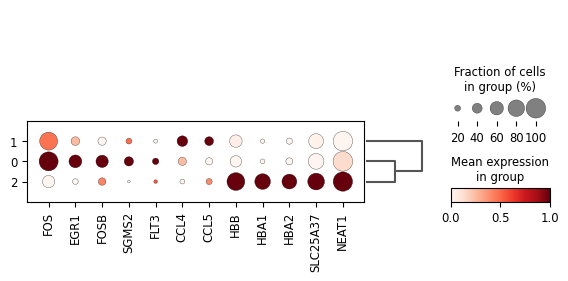

In [17]:
# Example usage:
flu_scgpt_markers, top_genes_flu_scgpt, ranked_genes_flu_scgpt = get_top_marker_genes(
    adata_flu_mono, groupby="leiden_scgpt", logfc_threshold=1.0, pval_threshold=0.05, top_n=5
)
sc.pl.dotplot(
    adata_flu_mono,
    var_names=flu_scgpt_markers,
    groupby="leiden_scgpt",
    standard_scale='var',
    dendrogram=True,
)

### Dotplot for Flu - PCA

/tmp/ipykernel_2725286/1186912933.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_df
/tmp/ipykernel_2725286/1186912933.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df


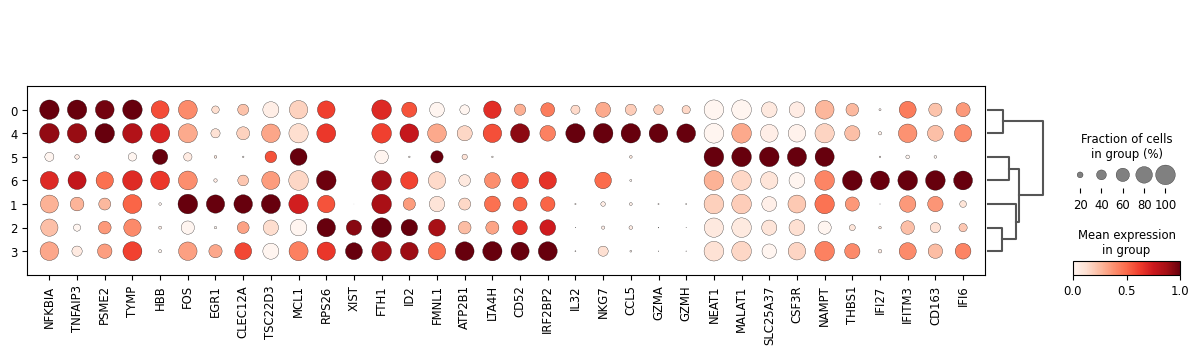

In [18]:
# Example usage:
flu_pca_markers, top_genes_flu_pca, ranked_genes_flu_pca = get_top_marker_genes(
    adata_flu_mono, groupby="leiden_pca", logfc_threshold=1.0, pval_threshold=0.05, top_n=5
)
sc.pl.dotplot(
    adata_flu_mono,
    var_names=flu_pca_markers,
    groupby="leiden_pca",
    standard_scale='var',
    dendrogram=True,
)

### Dotplot for Flu - scVI

/tmp/ipykernel_2725286/1186912933.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_df
/tmp/ipykernel_2725286/1186912933.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df


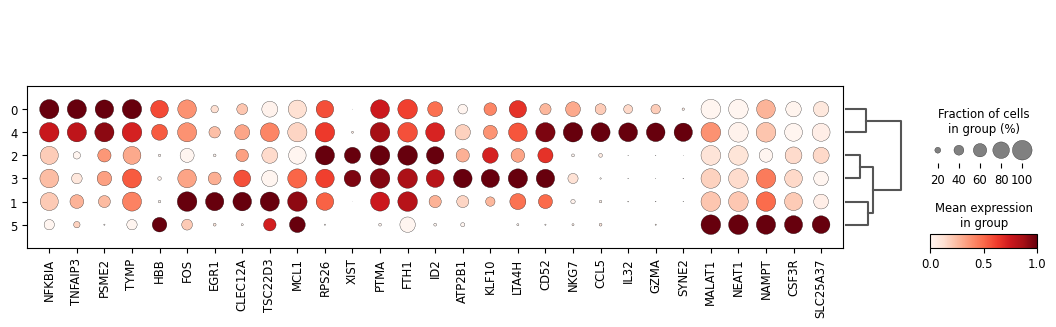

In [19]:
# Example usage:
flu_scvi_markers, top_genes_flu_scvi, ranked_genes_flu_scvi = get_top_marker_genes(
    adata_flu_mono, groupby="leiden_scvi", logfc_threshold=1.0, pval_threshold=0.05, top_n=5
)
sc.pl.dotplot(
    adata_flu_mono,
    var_names=flu_scvi_markers,
    groupby="leiden_scvi",
    standard_scale='var',
    dendrogram=True,
)

### Program Validation

## Utils

In [16]:
def get_top_marker_genes(
    adata, 
    groupby, 
    logfc_threshold=1.0, 
    pval_threshold=0.05, 
    top_n=5, 
    method="wilcoxon"
):
    """
    Compute and return top marker genes per cluster for an AnnData object.

    Parameters
    ----------
    adata : AnnData
        The AnnData object.
    groupby : str
        The column in adata.obs to group by (e.g., cluster labels).
    logfc_threshold : float
        Minimum log fold change for marker selection.
    pval_threshold : float
        Maximum adjusted p-value for marker selection.
    top_n : int
        Number of top genes per cluster to return.
    method : str
        Method for differential expression (default: "wilcoxon").

    Returns
    -------
    marker_genes : list
        List of unique top marker gene names.
    top_genes_per_cluster : pd.DataFrame
        DataFrame of top marker genes per cluster.
    """
    if "log1p" not in adata.uns:
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
    
    sc.tl.rank_genes_groups(adata, groupby=groupby, method=method)
    ranked_df = sc.get.rank_genes_groups_df(adata, None)
    filtered_df = ranked_df[
        (ranked_df["logfoldchanges"] > logfc_threshold) &
        (ranked_df["pvals_adj"] < pval_threshold)
    ]
    top_genes_per_cluster = (
        filtered_df
        .groupby("group")
        .apply(lambda g: g.sort_values("scores", ascending=False).head(top_n))
        .reset_index(drop=True)
    )
    marker_genes = top_genes_per_cluster["names"].unique().tolist()
    return marker_genes, top_genes_per_cluster, ranked_df

In [38]:
import gseapy
names = gseapy.get_library_name()
for name in names:
    # if "disgenet" in name.lower():
    print(name)

ARCHS4_Cell-lines
ARCHS4_IDG_Coexp
ARCHS4_Kinases_Coexp
ARCHS4_TFs_Coexp
ARCHS4_Tissues
Achilles_fitness_decrease
Achilles_fitness_increase
Aging_Perturbations_from_GEO_down
Aging_Perturbations_from_GEO_up
Allen_Brain_Atlas_10x_scRNA_2021
Allen_Brain_Atlas_down
Allen_Brain_Atlas_up
Azimuth_2023
Azimuth_Cell_Types_2021
BioCarta_2013
BioCarta_2015
BioCarta_2016
BioPlanet_2019
BioPlex_2017
CCLE_Proteomics_2020
COMPARTMENTS_Curated_2025
COMPARTMENTS_Experimental_2025
CORUM
COVID-19_Related_Gene_Sets
COVID-19_Related_Gene_Sets_2021
Cancer_Cell_Line_Encyclopedia
CellMarker_2024
CellMarker_Augmented_2021
ChEA_2013
ChEA_2015
ChEA_2016
ChEA_2022
Chromosome_Location
Chromosome_Location_hg19
ClinVar_2019
DGIdb_Drug_Targets_2024
DSigDB
Data_Acquisition_Method_Most_Popular_Genes
DepMap_CRISPR_GeneDependency_CellLines_2023
DepMap_WG_CRISPR_Screens_Broad_CellLines_2019
DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
Descartes_Cell_Types_and_Tissue_2021
Diabetes_Perturbations_GEO_2022
DisGeNET
Disease_

In [40]:
import os
import pandas as pd
from gseapy import prerank
from mygene import MyGeneInfo

def run_gsea_fast_serial(
    ranked_df,
    libraries=None,
    ranking_metric="logfoldchanges"
):
    if libraries is None:
        libraries = ["COVID-19_Related_Gene_Sets_2021"]

    # Step 1: Gene symbol mapping
    mg = MyGeneInfo()
    gene_ids = ranked_df["names"].unique().tolist()
    query_result = mg.querymany(
        gene_ids, scopes="symbol", fields="symbol", species="human", as_dataframe=True
    )
    query_result = query_result[~query_result.index.duplicated(keep="first")]
    mapped = query_result["symbol"].dropna().to_dict()

    ranked_df = ranked_df.copy()
    ranked_df["mapped_name"] = ranked_df["names"].map(mapped)
    ranked_df = ranked_df.dropna(subset=["mapped_name"])
    ranked_df["mapped_name"] = ranked_df["mapped_name"].str.upper()

    # Step 2: GSEA loop
    results = {}
    for cluster in ranked_df["group"].unique():
        cluster_df = ranked_df[ranked_df["group"] == cluster]
        rnk = cluster_df[["mapped_name", ranking_metric]]
        rnk.columns = ["gene_name", "score"]

        for lib in libraries:
            try:
                result = prerank(
                    rnk=rnk,
                    gene_sets=lib,
                    outdir=None,      # no file writing
                    no_plot=True,     # no plotting
                    format="png",
                    min_size=3,
                    max_size=1000,
                    permutation_num=100,
                    seed=42,
                    verbose=False,
                )
                results[(cluster, lib)] = result.res2d
            except Exception as e:
                print(f"⚠️ Failed GSEA for cluster {cluster} on {lib}: {e}")

    return results

In [41]:
gsea_flu_scgpt = run_gsea_fast_serial(ranked_genes_flu_scgpt)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
7456 input query terms found dup hits:	[('CAST', 2), ('MALAT1', 2), ('SNHG8', 2), ('WAC-AS1', 2), ('MIR23AHG', 3), ('GABPB1-AS1', 2), ('OTU
21602 input query terms found no hit:	['CD99_ENSG00000002586', 'METTL7A', 'MRPS36', 'ENSG00000268734.1', 'POLR2J3_ENSG00000285437', 'ENSG0
2025-06-04 11:40:30,388 [WARNING] Duplicated values found in preranked stats: 60.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-06-04 11:40:51,275 [WARNING] Duplicated values found in preranked stats: 60.23% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-06-04 11:40:55,920 [WARNING] Duplicated values found in preranked stats: 60.25% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [43]:
def gsea_results_to_df(results_dict, method_name):
    rows = []
    for (cluster, library), df in results_dict.items():
        required_cols = {"NES", "FDR q-val", "Term"}
        if not required_cols.issubset(df.columns):
            print(f"⚠️ Skipping {cluster} - {library}, missing columns: {required_cols - set(df.columns)}")
            continue

        for _, row in df.iterrows():
            rows.append({
                "method": method_name,
                "cluster": cluster,
                "library": library,
                "pathway": row["Term"],
                "NES": row["NES"],
                "FDR_qval": row["FDR q-val"],
            })
    return pd.DataFrame(rows)

In [144]:
gsea_flu_pca = run_gsea_fast_serial(ranked_genes_flu_pca)
gsea_flu_scvi = run_gsea_fast_serial(ranked_genes_flu_scvi)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
7456 input query terms found dup hits:	[('TRBC1', 2), ('TRBC2', 2), ('PDCD4-AS1', 2), ('USP30-AS1', 2), ('RNASE2CP', 2), ('WAKMAR2', 2), ('
21602 input query terms found no hit:	['ENSG00000262202.4', 'FCGR1BP_ENSG00000198019', 'C4orf3', 'ENSG00000276216.1', 'ENSG00000233461.6',
2025-05-31 21:05:45,283 [WARNING] Duplicated values found in preranked stats: 60.23% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-05-31 21:06:00,672 [WARNING] Duplicated values found in preranked stats: 60.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-05-31 21:06:17,180 [WARNING] Duplicated values found in preranked stats: 60.24% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-05-31 21:06:32,140 [WARNING] Duplica

In [11]:
def gsea_results_to_df(results_dict, method_name):
    rows = []
    for (cluster, library), df in results_dict.items():
        required_cols = {"NES", "FDR q-val", "Term"}
        if not required_cols.issubset(df.columns):
            print(f"⚠️ Skipping {cluster} - {library}, missing columns: {required_cols - set(df.columns)}")
            continue

        for _, row in df.iterrows():
            rows.append({
                "method": method_name,
                "cluster": cluster,
                "library": library,
                "pathway": row["Term"],
                "NES": row["NES"],
                "FDR_qval": row["FDR q-val"],
            })
    return pd.DataFrame(rows)

In [148]:
gsea_flu_df_scgpt = gsea_results_to_df(gsea_flu_scgpt, "scGPT")
gsea_flu_df_pca = gsea_results_to_df(gsea_flu_pca, "PCA")
gsea_flu_df_scvi = gsea_results_to_df(gsea_flu_scvi, "scVI")

gsea_flu_combined_df = pd.concat([gsea_flu_df_scgpt, gsea_flu_df_pca, gsea_flu_df_scvi])

In [172]:
gsea_flu_combined_df.to_csv("gsea_flu_combined_df.csv")

In [ ]:
# Choose a reasonable FDR threshold
flu_sig_df = gsea_flu_combined_df[gsea_flu_combined_df["FDR_qval"] < 1]

In [173]:
gsea_covid_scgpt = run_gsea_fast_serial(ranked_genes_covid_scgpt)
gsea_covid_pca = run_gsea_fast_serial(ranked_genes_covid_pca)
gsea_covid_scvi = run_gsea_fast_serial(ranked_genes_covid_scvi)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
7456 input query terms found dup hits:	[('SNHG6', 2), ('CHASERR', 2), ('IGHA1', 2), ('WASH4P', 2), ('MAP3K5-AS2', 2), ('IGLV1-40', 2), ('GA
21602 input query terms found no hit:	['ENSG00000257764.2', 'ENSG00000273149.1', 'MATR3_ENSG00000015479', 'ENSG00000234961.1', 'ENSG000002
2025-05-31 21:29:10,506 [WARNING] Duplicated values found in preranked stats: 49.34% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-05-31 21:29:25,692 [WARNING] Duplicated values found in preranked stats: 49.33% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-05-31 21:29:41,407 [WARNING] Duplicated values found in preranked stats: 49.37% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-05-31 21:29:55,888 [WARNING] Duplica

In [175]:
gsea_covid_df_scgpt = gsea_results_to_df(gsea_covid_scgpt, "scGPT")
gsea_covid_df_pca = gsea_results_to_df(gsea_covid_pca, "PCA")
gsea_covid_df_scvi = gsea_results_to_df(gsea_covid_scvi, "scVI")

gsea_covid_combined_df = pd.concat([gsea_covid_df_scgpt, gsea_covid_df_pca, gsea_covid_df_scvi])
gsea_covid_combined_df.to_csv("gsea_covid_combined_df.csv")

In [182]:
# Choose a reasonable FDR threshold
covid_sig_df = gsea_covid_combined_df[gsea_covid_combined_df["FDR_qval"] < 0.25]
covid_sig_df

,method,cluster,library,pathway,NES,FDR_qval
0,scGPT,0,Reactome_2022,Expression And Translocation Of Olfactory Rece...,-1.652056,0.000000
1,scGPT,0,Reactome_2022,Olfactory Signaling Pathway R-HSA-381753,-1.648888,0.000000
1806,scGPT,1,Reactome_2022,Expression And Translocation Of Olfactory Rece...,1.758741,0.000000
1807,scGPT,1,Reactome_2022,Olfactory Signaling Pathway R-HSA-381753,1.742056,0.000000
1808,scGPT,1,Reactome_2022,Asymmetric Localization Of PCP Proteins R-HSA-...,-1.612421,0.226037
5418,scGPT,3,Reactome_2022,Apoptosis Induced DNA Fragmentation R-HSA-140342,1.933579,0.000000
7,PCA,0,Reactome_2022,"Respiratory Electron Transport, ATP Synthesis ...",1.527083,0.238938
8,PCA,0,Reactome_2022,Mitochondrial Translation Termination R-HSA-54...,1.525686,0.217930
9,PCA,0,Reactome_2022,Regulation Of Apoptosis R-HSA-169911,1.516222,0.239354
10,PCA,0,Reactome_2022,DNA Damage/Telomere Stress Induced Senescence ...,1.512860,0.220617


In [3]:
adata_covid_mono = sc.read("../data/embeddings/covid_mono.h5ad")
adata_flu_mono = sc.read("../data/embeddings/flu_mono.h5ad")

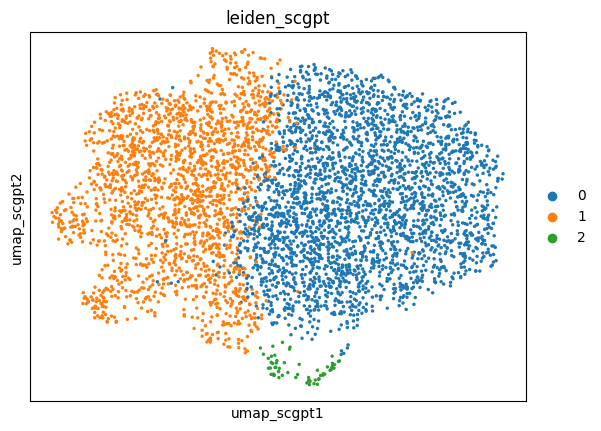

In [11]:
sc.pl.embedding(adata_flu_mono, basis="umap_scgpt", color="leiden_scgpt")

In [ ]:
adata_flu_mono.

View of AnnData object with n_obs × n_vars = 5070 × 2000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'predictions', 'predicted_celltype', 'true_coarse', 'pred_coarse'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_type_colors', 'hvg', 'neighbors', 'pca', 'pred_coarse_colors', 'predictions_colors', 'true_coarse_col

In [14]:
sc.pp.neighbors(adata_flu_mono, use_rep=f"X_scgpt")
sc.tl.leiden(adata_flu_mono, resolution=0.2, key_added=f"leiden_scgpt_hvg")
sc.tl.umap(adata_flu_mono)
adata_flu_mono.obsm[f"X_umap_scgpt"] = adata_flu_mono.obsm["X_umap"].copy()

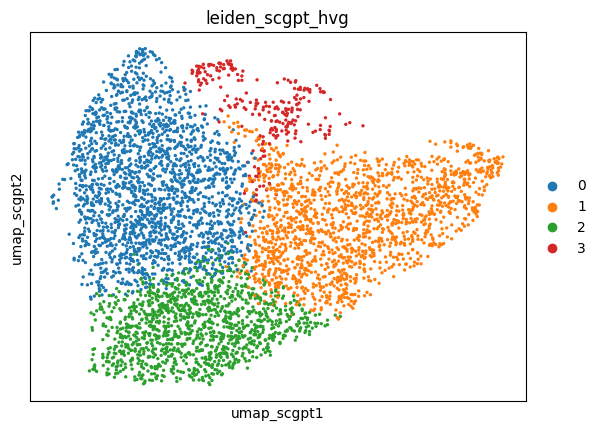

In [15]:
sc.pl.embedding(adata_flu_mono, basis="umap_scgpt", color="leiden_scgpt_hvg")

/tmp/ipykernel_1572665/1186912933.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_df
/tmp/ipykernel_1572665/1186912933.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df


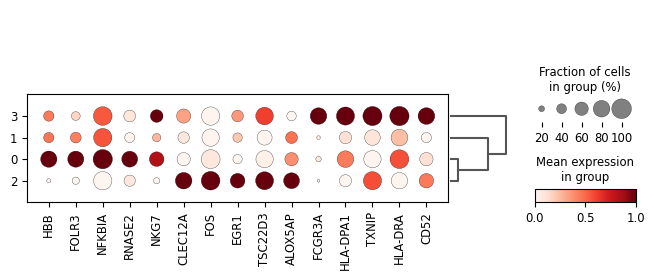

In [17]:
# Example usage:
flu_scgpt_hvg_markers, top_genes_flu_scgpt_hvg, ranked_genes_flu_scgpt_hvg = get_top_marker_genes(
    adata_flu_mono, groupby="leiden_scgpt_hvg", logfc_threshold=1.0, pval_threshold=0.05, top_n=5
)
sc.pl.dotplot(
    adata_flu_mono,
    var_names=flu_scgpt_hvg_markers,
    groupby="leiden_scgpt_hvg",
    standard_scale='var',
    dendrogram=True,
)